# Fraud Detection Using AutoEncoders - An Unsupervised Learning Method

In this lab we'll use a credit card fraud dataset to predict fraudulent transactions.  This dataset The contains transactions made by credit cards in September 2013 by European cardholders.  This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions (Highly Imbalanced!)

## Introduction

In many real life situations, you do not have labeled data and still you need to detect fraudaulent activites. This technique walks you through how to learn features and build a model using unlabeled dataset and helps you to detect frauds.

In [174]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import os
import sagemaker
from sklearn.metrics import recall_score, classification_report, auc, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sagemaker.predictor import csv_serializer 
from sklearn.preprocessing import StandardScaler
from sagemaker.tensorflow import TensorFlow


In [1]:
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from keras import regularizers
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score,accuracy_score
from sklearn.metrics import confusion_matrix, precision_recall_curve,cohen_kappa_score
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


In [2]:
# sagemaker session
session = sagemaker.Session()
sagemaker_iam_role = sagemaker.get_execution_role()

# data location
bucket = session.default_bucket()
prefix = 'sagemaker/DEMO-autoencoder-fraud'

## Investigate and process the data

Let's start by downloading and reading in the credit card fraud data set.

In [3]:
# creating directory structure
!mkdir -p ./data

In [4]:
# download from s3 to the ./data/ folder
!curl https://s3-us-west-2.amazonaws.com/sagemaker-e2e-solutions/fraud-detection/creditcardfraud.zip -o ./data/creditcardfraud.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.9M  100 65.9M    0     0  14.2M      0  0:00:04  0:00:04 --:--:-- 15.0M


In [5]:
# uncompress the dataset
!unzip -o ./data/creditcardfraud.zip -d ./data/

Archive:  ./data/creditcardfraud.zip
  inflating: ./data/creditcard.csv   


In [175]:
# read in data with pandas
data = pd.read_csv('./data/creditcard.csv', delimiter=',')

Let's take a peek at our data (we only show a subset of the columns in the table):

In [176]:
print(data.columns)
data.head(10)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


Last column represents the class i.e fraud or non-fraud. Let's plot this class against the Frequency to see how the data is distributed. We are not going to use this label as its a non-supervised technique.

This dataset has 28 columns, $V_i$ for $i=1..28$ of anonymized features along with columns for time, amount, and class. We already know that the columns $V_i$ have been normalized to have $0$ mean and unit standard deviation as the result of a PCA. You can read more about PCA here - https://en.wikipedia.org/wiki/Principal_component_analysis 

In [177]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [178]:
nonfrauds, frauds = data.groupby('Class').size()
print('Number of frauds: ', frauds)
print('Number of non-frauds: ', nonfrauds)
print('Percentage of fradulent data: {:.3%}'.format(frauds/(frauds + nonfrauds)))

Number of frauds:  492
Number of non-frauds:  284315
Percentage of fradulent data: 0.173%


The class column corresponds to whether or not a transaction is fradulent. We see that the majority of data is non-fraudulant with only $492$ ($.173\%$) of the data corresponding to fraudulant examples.

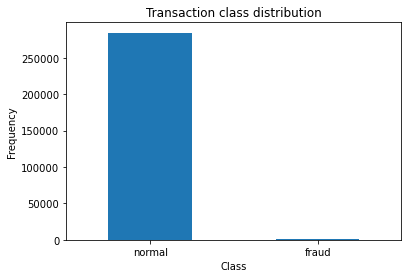

In [179]:
labels = ['normal','fraud']
classes = pd.value_counts(data['Class'], sort = True)
classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency");

It clearly indicates that its a highly imbalanced dataset.

In [180]:
feature_columns = data.columns[:-1]
label_column = data.columns[-1]

features = data[feature_columns].values.astype('float32')
labels = (data[label_column].values).astype('float32')

### Prepare Data and Upload to S3

In [181]:
# move class to the first column
model_data = data
model_data = pd.concat([model_data['Class'], model_data.drop(['Class'], axis=1)], axis=1)
model_data.head()

,Class,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,0,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,0,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,0,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [182]:
# data split and save as CSV - 70/20/10
train_df, temp_df = train_test_split(model_data, test_size=0.3, random_state=4321, shuffle=True, stratify=model_data['Class'])
val_df, test_df = train_test_split(temp_df, test_size=0.33333, random_state=4321, shuffle=True, stratify=temp_df['Class'])

Other part to note is that we have two columns Time and Amount which are not scaled. So let's scale them by using standard scaler from sklearn. 

In [183]:
time_scaler = StandardScaler()
time_scaler.fit(train_df['Time'].values.reshape(-1, 1))
train_df['Time'] = time_scaler.transform(train_df['Time'].values.reshape(-1, 1))
val_df['Time'] = time_scaler.transform(val_df['Time'].values.reshape(-1, 1))
test_df['Time'] = time_scaler.transform(test_df['Time'].values.reshape(-1, 1))

amount_scaler = StandardScaler()
amount_scaler.fit(train_df['Amount'].values.reshape(-1, 1))
train_df['Amount'] = amount_scaler.transform(train_df['Amount'].values.reshape(-1, 1))
val_df['Amount'] = amount_scaler.transform(val_df['Amount'].values.reshape(-1, 1))
test_df['Amount'] = amount_scaler.transform(test_df['Amount'].values.reshape(-1, 1))


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [184]:
train_df.describe()

,Class,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,199364.000000,1.993640e+05,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,...,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,1.993640e+05
mean,0.001725,-1.506372e-16,-0.002009,0.003005,0.003090,-0.000168,0.003672,-0.001616,0.002083,0.003794,...,0.000635,0.000955,0.000795,-0.000434,0.000463,-0.000481,0.001015,-0.000506,0.000318,1.606286e-16
std,0.041503,1.000003e+00,1.961334,1.660060,1.516842,1.417937,1.376368,1.329466,1.227309,1.162634,...,0.770646,0.720478,0.725088,0.624577,0.605916,0.522775,0.483053,0.406313,0.336730,1.000003e+00
min,0.000000,-1.995479e+00,-56.407510,-72.715728,-48.325589,-5.600607,-113.743307,-26.160506,-41.506796,-39.267378,...,-54.497720,-21.620120,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,-3.515120e-01
25%,0.000000,-8.545191e-01,-0.921238,-0.596256,-0.886571,-0.848094,-0.687877,-0.768851,-0.551564,-0.207594,...,-0.210910,-0.227778,-0.540843,-0.162183,-0.353853,-0.317866,-0.326741,-0.071041,-0.052894,-3.295306e-01
50%,0.000000,-2.128446e-01,0.012373,0.069705,0.182427,-0.020441,-0.052284,-0.275597,0.041495,0.023071,...,-0.062187,-0.028968,0.007272,-0.011203,0.041027,0.016486,-0.049804,0.001302,0.011438,-2.636265e-01
75%,0.000000,9.374173e-01,1.314058,0.805468,1.031672,0.743334,0.613678,0.397749,0.572310,0.327794,...,0.133038,0.187237,0.530138,0.147347,0.439409,0.350335,0.241754,0.091326,0.078681,-4.377293e-02
max,1.000000,1.641029e+00,2.454930,21.467203,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,...,39.420904,27.202839,8.361985,22.528412,4.584549,7.519589,3.463246,31.612198,33.847808,1.023261e+02


In [185]:
train_df.to_csv('./data/train.csv', header=False, index=False)
val_df.to_csv('./data/validation.csv', header=False, index=False)
test_df.to_csv('./data/test.csv', header=False, index=False)

## Build the Model - AutoEncoder

AutoEncoders are special kind of neural networks, where your input is 'x' and you have your output as 'x' as well. What this really means is that we are trying to learn a function, where the input and output are the same.  

Few things to note. 

- We are reducing the number of nodes, which will force network to learn the features from the dataset. Intuition being that this "code" is a set of abstracted features which represents or creates a fingerprint for "fraud" or a "non-fraud" activitiy.
- Since we are starting with the input 'x', reducing into a abstracted features and then reconstructing back the 'x' means we don't need a labeled dataset. 
- The "code" is intutively a representation of abstracted features. In case of credit card frauds features abstraction would be "when does a fraud occur?". It can be a credit card transaction by the same person, from multiple places, using the same credit card etc.

For our credit card dataset, we are going to get all the non-fraudulent data and will try to re-create the same (f(x) = x). During this process the network should try to learn a unique representation of what's a non-fradulent activity. Once the model is trained with whats 'normal' that means anything which does not match this normal representation can be declared as abnormal. 

For inference, we are going to give both fraud and non-fraud data to the model. Model prediction will allow us to calculate the reconstruction error. This is where we set the threshold which let's domain expert define what tolerance is ok consider normal and when to declare as abnormal data. 

In [186]:
train_x = train_df.loc[train_df['Class'] == 0]
train_x = train_x.drop(['Class'], axis=1)
train_x.to_csv('./data/train_normal.csv', header=False, index=False)

In [243]:
val_df.to_csv('./data/validation_normal.csv', index=False)

In [188]:
test_y = test_df['Class']
test_x = test_df.drop(['Class'], axis=1)

Let's check one more time, what columns are being used in the training dataset

In [244]:
print(train_x.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')


In [245]:
print('Shapes are: Train=',train_x.shape,' Test=',test_x.shape)

Shapes are: Train= (199020, 30)  Test= (28481, 30)


### Now we upload the data to S3 using boto3.

In [246]:
output_location = f's3://{bucket}/{prefix}/output'
s3_train_data = f's3://{bucket}/{prefix}/train/train_normal.csv'
s3_validation_data = f's3://{bucket}/{prefix}/validation/validation_normal.csv'

# upload to s3 bucket defined above
session.upload_data('./data/train_normal.csv',bucket,f'{prefix}/train')
session.upload_data('./data/validation_normal.csv',bucket,f'{prefix}/validation')

print('Uploaded training data location: {}'.format(s3_train_data))
print('Uploaded training data location: {}'.format(s3_validation_data))
print('Training artifacts will be uploaded to: {}'.format(output_location))

Uploaded training data location: s3://sagemaker-us-east-1-431615879134/sagemaker/DEMO-autoencoder-fraud/train/train_normal.csv
Uploaded training data location: s3://sagemaker-us-east-1-431615879134/sagemaker/DEMO-autoencoder-fraud/validation/validation_normal.csv
Training artifacts will be uploaded to: s3://sagemaker-us-east-1-431615879134/sagemaker/DEMO-autoencoder-fraud/output


## Build the Model - AutoEncoder

We are going to create two layers both for encoders and decoders. 

First layer will have the dimension close to half of the input dimension to the network and 2nd layer will be half of the 1st layer. In this case it will be 14 and 7

In [247]:
!pygmentize ./code/fraud_ae_tf.py

import argparse, os
import numpy as np
import pandas as pd

import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import regularizers

from keras.utils import multi_gpu_model

if __name__ == '__main__':
        
    parser = argparse.ArgumentParser()

    parser.add_argument('--epochs', type=int, default=20)
    parser.add_argument('--learning-rate', type=float, default=0.001)
    parser.add_argument('--batch-size', type=int, default=128)
    parser.add_argument('--activation', type=str, default="relu")
    parser.add_argument('--dropout', type=float, default=0.0)
    parser.add_argument('--gpu-count', type=int, default=os.environ['SM_NUM_GPUS'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--training', type=str, default=os.environ['SM_CHANNEL_TRAINING'])
    parser.add_argument('--validation', type=str, default=os.environ['SM_CHANNE

## Train the AutoEncoder Model

In [248]:
tf_estimator = TensorFlow(entry_point='./code/fraud_ae_tf.py', 
                          role=sagemaker_iam_role,
                          instance_count=1, 
                          instance_type='ml.m5.xlarge',
                          framework_version='1.12', 
                          py_version='py3',
                          script_mode=True,
                          use_spot_instances=True,
                          max_run=3600,
                          max_wait=3600,
                          hyperparameters={
                              'epochs': 25,
                              'batch-size': 256,
                              'learning-rate': 0.0002}
                         )

In [249]:
tf_estimator.fit({'training': s3_train_data, 'validation': s3_validation_data})

2021-07-20 19:24:40 Starting - Starting the training job...
2021-07-20 19:25:03 Starting - Launching requested ML instancesProfilerReport-1626809080: InProgress
.........
2021-07-20 19:26:25 Starting - Preparing the instances for training......
2021-07-20 19:27:35 Downloading - Downloading input data...
2021-07-20 19:28:05 Training - Training image download completed. Training in progress..2021-07-20 19:28:05,289 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-07-20 19:28:05,295 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-07-20 19:28:12,735 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-07-20 19:28:12,749 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-07-20 19:28:12,759 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/m

## Predicting with AutoEncoder

Let's first deploy the trained model to a real time endpoint

In [251]:
%%time

import time 
tf_endpoint_name = 'keras-tf-autoencoder-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

tf_predictor = tf_estimator.deploy(initial_instance_count=1,
                         instance_type='ml.m5.xlarge',      
                         endpoint_name=tf_endpoint_name)    

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----------!CPU times: user 151 ms, sys: 16.7 ms, total: 167 ms
Wall time: 5min 32s


We are going to calculate the mean absolute error between predicted and the expected values. This will be our reconstruction error.  We can process the whole test dataset at once.  Note that if we needed to we could chunk the data to predict in batches.  The endpoint timeout duration will dictate if we batch or not.

In [252]:
y_pred = tf_predictor.predict(test_x.to_numpy())
mse = np.mean(np.abs(test_x.to_numpy() - y_pred['predictions']), axis=1)

Let's see how is reconstuction error w.r.t predicted class

In [253]:
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': test_y})
error_df.describe()

,reconstruction_error,true_class
count,28481.000000,28481.000000
mean,0.410042,0.001720
std,0.210964,0.041443
min,0.140273,0.000000
25%,0.295712,0.000000
50%,0.368424,0.000000
75%,0.469757,0.000000
max,7.426070,1.000000


## Reconstruction error without fraud

In [254]:
error_df[(error_df['true_class']== 0)]['reconstruction_error'].describe()

count    28432.000000
mean         0.406640
std          0.180846
min          0.140273
25%          0.295634
50%          0.368216
75%          0.469229
max          4.630294
Name: reconstruction_error, dtype: float64

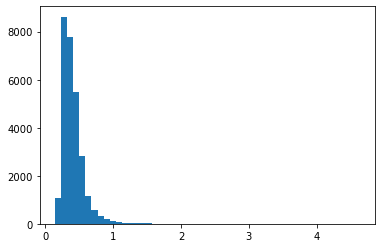

In [255]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'])]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=50)


## Reconstruction error with fraud

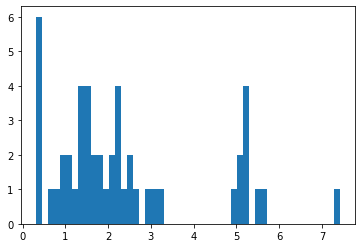

In [256]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=50)

Text(0, 0.5, 'normalized count')

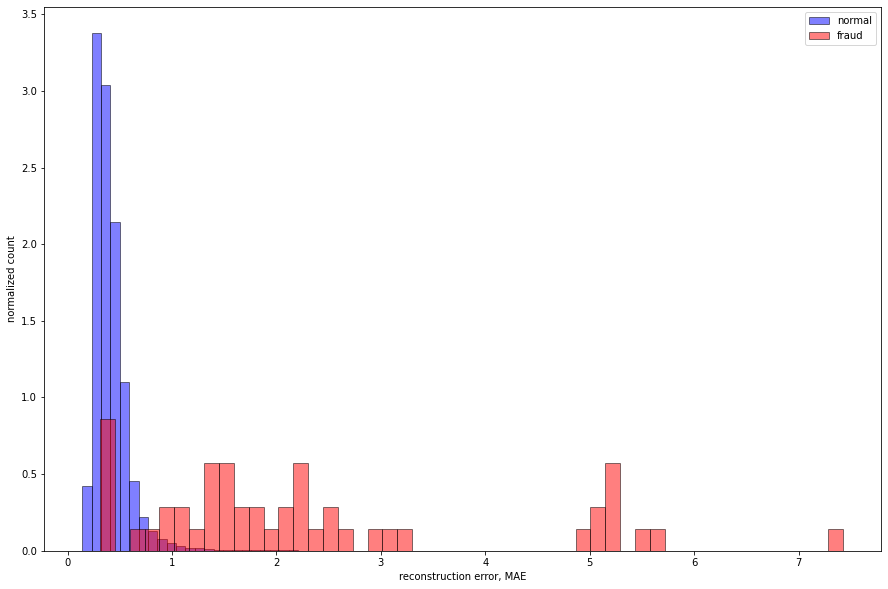

In [257]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
_ = ax.hist(error_df[error_df['true_class']==0]['reconstruction_error'].values, bins=50,density=True,color='blue',edgecolor='black',alpha=0.5,label='normal')
_ = ax.hist(error_df[error_df['true_class']==1]['reconstruction_error'], bins=50,density=True,color='red',edgecolor='black',alpha=0.5,label='fraud')
plt.legend()
plt.xlabel('reconstruction error, MAE')
plt.ylabel('normalized count')
#plt.ylim((0,50))

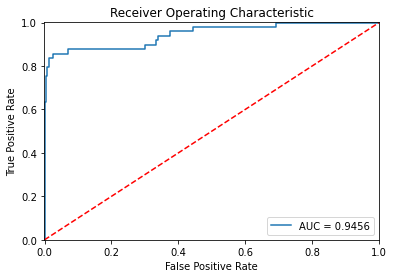

In [258]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

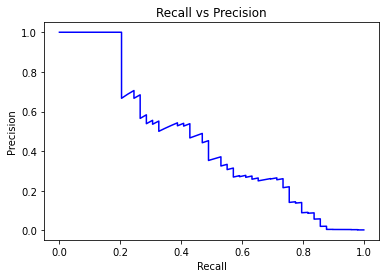

In [259]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

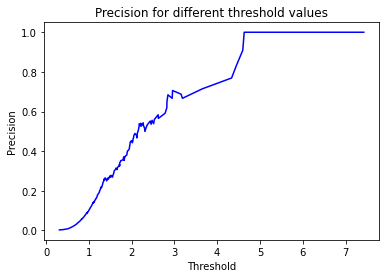

In [260]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

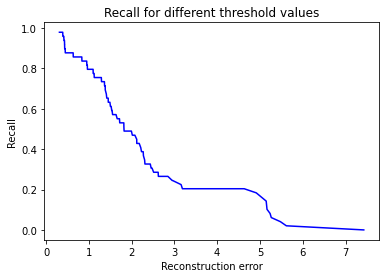

In [261]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [262]:
threshold = 2

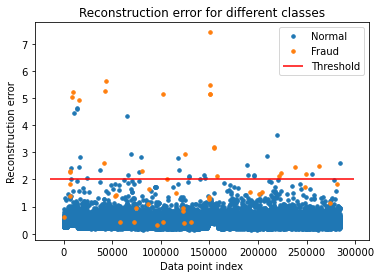

In [263]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [264]:
LABELS = ["Normal", "Fraud"]

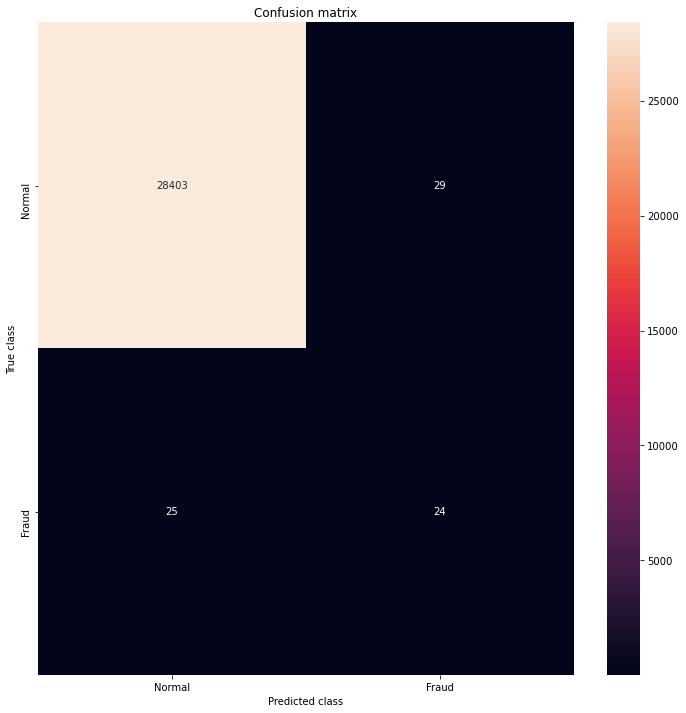

In [265]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [266]:
print("Classification Report: ")
print(classification_report(y_true=error_df.true_class, y_pred=y_pred))

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.45      0.49      0.47        49

    accuracy                           1.00     28481
   macro avg       0.73      0.74      0.73     28481
weighted avg       1.00      1.00      1.00     28481



In [267]:
# clean up
tf_predictor.delete_endpoint()

## Data Acknowledgements


The dataset used to demonstrated the fraud detection solution has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project We cite the following works:

- Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015
- Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon
- Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE
- Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)
- Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier
- Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing